# Chapter 12. CNN - 이미지 분류를 응용한 문서 분류



## 2. CNN을 이용한 문서 분류


### 2.1 NLTK 영화 리뷰 데이터 변환



In [1]:
import keras 
print(keras.__version__)

2.7.0


In [2]:
# from tensorflow.compat.v1 import ConfigProto
# from tensorflow.compat.v1 import InteractiveSession

# config = ConfigProto()
# config.gpu_options.allow_growth = True
# session = InteractiveSession(config=config)

In [3]:
# import tensorflow as tf
# def set_tensorflow_config(per_process_gpu_memory_fraction=0.8):
#     config = tf.compat.v1.ConfigProto()
#     # config = tf.ConfigProto()
#     config.gpu_options.per_process_gpu_memory_fraction = per_process_gpu_memory_fraction
#     config.gpu_options.allow_growth=True
#     # sess = tf.Session(config=config)
#     sess = tf.compat.v1.Session(config=config)
    
#     print("== TensorFlow Config options set ==")
#     print("\nThis process will now utilize {} GPU Memeory Fraction".format(per_process_gpu_memory_fraction))

# set_tensorflow_config()

In [4]:
# !pip install keras==2.2.4
# !pip install keras==2.7.0
# !pip install keras==2.7.0

In [5]:
import keras 
print(keras.__version__)

2.7.0


In [6]:
import tensorflow as tf
# physical_devices = tf.config.list_physical_devices('GPU')
# tf.config.experimental.set_memory_growth(physical_devices[0], enable=False)

In [7]:
from nltk.corpus import movie_reviews
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split 

#movie review data에서 file id를 가져옴
fileids = movie_reviews.fileids() 
#file id를 이용해 raw text file을 가져옴
reviews = [movie_reviews.raw(fileid) for fileid in fileids] 
categories = [movie_reviews.categories(fileid)[0] for fileid in fileids] 

np.random.seed(7)
tf.random.set_seed(7)

max_words = 10000 #사용할 단어의 수
maxlen = 500 #문서의 단어 수를 제한

# 빈도가 높은 10000개의 단어를 선택하도록 객체 생성
tokenizer = Tokenizer(num_words=max_words, oov_token='UNK') 
tokenizer.fit_on_texts(reviews) #단어 인덱스 구축

X = tokenizer.texts_to_sequences(reviews) #만들어진 단어 인덱스를 이용해 변환
X = pad_sequences(X, maxlen=maxlen, truncating='pre') 

# label을 0, 1의 값으로 변환
label_dict = {'pos':0, 'neg':1}
y = np.array([label_dict[c] for c in categories])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

In [8]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(1600, 500)
(400, 500)
(1600,)
(400,)


### 2.2 CNN 모형 생성 및 학습

In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D
from tensorflow.keras.layers import Embedding, Dropout, Flatten
from tensorflow.keras.optimizers import Adam

model = Sequential([
    #word embedding layer 생성
    Embedding(max_words, 64, input_length=maxlen), # (500,64)
    Conv1D(128, # 채널의 수
            5, # 1D 필터 크기
            padding='valid', 
            activation='relu',
            strides=1), 
    MaxPooling1D(pool_size=2),
    Conv1D(256, # 채널의 수
            5, # 1D 필터 크기
            padding='valid', 
            activation='relu',
            strides=1), 
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid') #binary logistic regression을 수행
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 500, 64)           640000    
                                                                 
 conv1d (Conv1D)             (None, 496, 128)          41088     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 248, 128)         0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 244, 256)          164096    
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 122, 256)         0         
 1D)                                                             
                                                                 
 flatten (Flatten)           (None, 31232)             0

In [10]:
X_train.shape

(1600, 500)

In [11]:
y_train.shape

(1600,)

In [12]:
adam = Adam(learning_rate=1e-3)
model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['acc'])

history = model.fit(X_train, y_train, 
                    epochs=20,
                    batch_size=256,
                    verbose=1,
                    validation_split=0.2)

Epoch 1/20
5/5 [==============================] - 5s 825ms/step - loss: 0.7183 - acc: 0.5289 - val_loss: 0.6940 - val_acc: 0.4969
Epoch 2/20
5/5 [==============================] - 3s 690ms/step - loss: 0.6933 - acc: 0.4969 - val_loss: 0.6931 - val_acc: 0.4969
Epoch 3/20
5/5 [==============================] - 3s 653ms/step - loss: 0.6926 - acc: 0.4969 - val_loss: 0.6928 - val_acc: 0.4969
Epoch 4/20
5/5 [==============================] - 3s 642ms/step - loss: 0.6917 - acc: 0.5164 - val_loss: 0.6924 - val_acc: 0.4969
Epoch 5/20
5/5 [==============================] - 3s 636ms/step - loss: 0.6894 - acc: 0.5406 - val_loss: 0.6920 - val_acc: 0.4969
Epoch 6/20
5/5 [==============================] - 3s 645ms/step - loss: 0.6839 - acc: 0.6414 - val_loss: 0.6906 - val_acc: 0.5562
Epoch 7/20
5/5 [==============================] - 3s 693ms/step - loss: 0.6700 - acc: 0.8547 - val_loss: 0.6855 - val_acc: 0.5594
Epoch 8/20
5/5 [==============================] - 4s 747ms/step - loss: 0.6431 - acc: 0.75

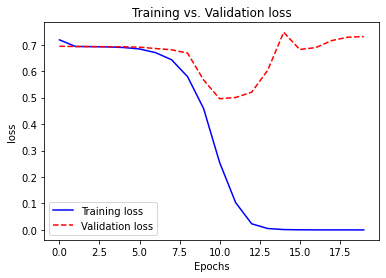

13/13 [==============================] - 0s 23ms/step - loss: 0.7311 - acc: 0.8000
#Test accuracy:0.800


In [13]:
%matplotlib inline
import matplotlib.pyplot as plt

def plot_results(history, metric):
    plt.plot(history.history[metric], 'b', label='Training '+metric)
    plt.plot(history.history['val_'+metric], 'r--', label='Validation '+metric)
    plt.title('Training vs. Validation '+metric)
    plt.xlabel('Epochs')
    plt.ylabel(metric)
    plt.legend()
    plt.show()

plot_results(history, 'loss')

#테스트 셋으로 학습된 모형의 성능을 평가
score = model.evaluate(X_test, y_test)
print(f'#Test accuracy:{score[1]:.3f}')